In [7]:
#Python packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)
import re
from scipy import stats

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#ML modeling packages
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

### Competition Overview

Significant investments are being made to improve building efficiencies to reduce costs and emissions. The question is, are the improvements working? That’s where you come in. Under pay-for-performance financing, the building owner makes payments based on the difference between their real energy consumption and what they would have used without any retrofits. The latter values have to come from a model. Current methods of estimation are fragmented and do not scale well. Some assume a specific meter type or don’t work with different building types.

In this competition, you’ll develop accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe. With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

In [2]:
meta = pd.read_csv('building_metadata.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
w_train = pd.read_csv('weather_train.csv')
w_test = pd.read_csv('weather_test.csv')

In [3]:
print('meta shape:',meta.shape)
print('train shape:',train.shape)
print('test shape:',test.shape)
print('weather_train shape:',w_train.shape)
print('weather_test shape:',w_test.shape)

meta shape: (1449, 6)
train shape: (20216100, 4)
test shape: (41697600, 4)
weather_train shape: (139773, 9)
weather_test shape: (277243, 9)


In [3]:
train = train.merge(meta, on = 'building_id', how = 'left')
test = test.merge(meta, on = 'building_id', how = 'left')

train = train.merge(w_train, on = ['site_id', 'timestamp'], how = 'left')
test = test.merge(w_test, on = ['site_id', 'timestamp'], how = 'left')

del w_train, w_test, meta

In [4]:
'''Function to reduce the DF size'''
# source: https://www.kaggle.com/kernels/scriptcontent/3684066/download

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 2622.02 MB
Memory usage after optimization is: 790.84 MB
Decreased by 69.8%
Memory usage of dataframe is 5408.17 MB
Memory usage after optimization is: 1631.16 MB
Decreased by 69.8%


#### Variables of Train

building_id - Foreign key for the building metadata.

meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.

timestamp - When the measurement was taken

#### TARGET
meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

In [9]:
train.to_csv('train_reduced.csv')
test.to_csv('test_reduced.csv')

In [7]:
'''Variable Description'''
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary

In [8]:
description(train)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,building_id,int16,0,1449,0,1,2
1,meter,int8,0,4,0,0,0
2,timestamp,category,0,8784,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
3,meter_reading,float32,0,1688175,0,0,0
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,int32,0,1397,7432,2720,5376
7,year_built,float16,12127645,116,2008,2004,1991
8,floor_count,float16,16709167,18,NaN,NaN,NaN
9,air_temperature,float16,96658,619,25,25,25


In [9]:
corr_matrix = train.corr()
corr_matrix['meter'].sort_values(ascending=False)

meter                 1.000000
site_id               0.253875
building_id           0.222268
floor_count           0.176926
square_feet           0.132708
meter_reading         0.017672
precip_depth_1_hr    -0.002283
year_built           -0.003798
air_temperature      -0.011158
wind_direction       -0.022276
sea_level_pressure   -0.052593
dew_temperature      -0.080445
wind_speed           -0.081172
cloud_coverage       -0.177186
Name: meter, dtype: float64

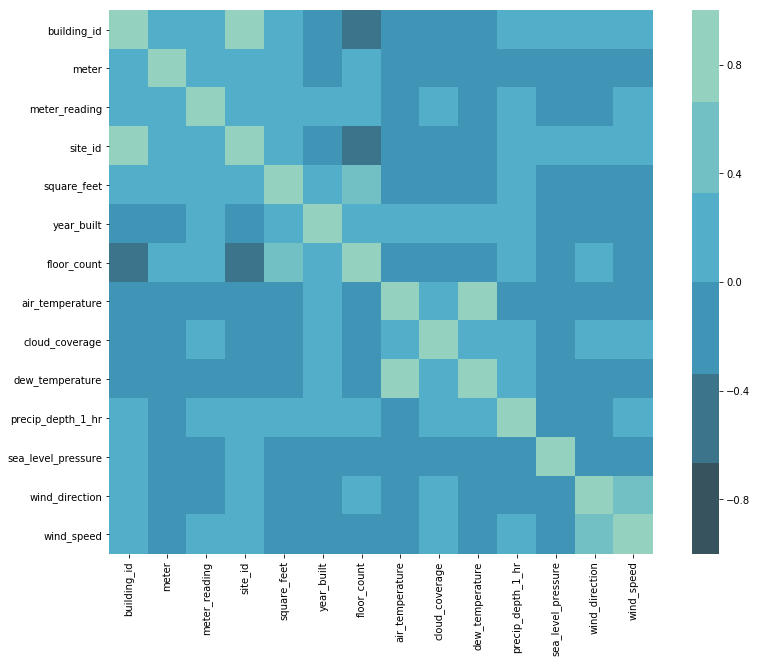

In [22]:
plt.rcParams['figure.figsize'] = (14,10)
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0, linecolor = 'black',
            square=True, cmap = sns.color_palette("GnBu_d"))

In [28]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['hour'] = np.uint8(train['timestamp'].dt.hour)
train['day'] = np.uint8(train['timestamp'].dt.day)
train['weekday_name']=train['timestamp'].dt.weekday_name
train['weekday'] = np.uint8(train['timestamp'].dt.weekday)
train['month'] = np.uint8(train['timestamp'].dt.month)

In [32]:
usage = list(train['primary_use'].unique())
len(usage)

16

In [40]:
cb_dark_blue = (0/255, 107/255, 164/255)
cb_orange = (255/255, 128/255, 14/255)

usage = list(train['primary_use'].unique())
stem_cats = ['Engineering', 'Computer Science', 'Psychology', 'Biology', 'Physical Sciences', 'Math and Statistics']

fig = plt.figure(figsize=(18, 3))

for sp in range(0,16):
    ax = fig.add_subplot(1,16,sp+1)
    ax.plot(train['month'], train['square_feet'], c=cb_dark_blue, label='Women', linewidth=3)
    ax.plot(train['month'], 100-train['square_feet'], c=cb_orange, label='Men', linewidth=3)
    for key,spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xlim(1968, 2011)
    ax.set_ylim(0,100)
    ax.set_title(usage[sp])
    ax.tick_params(bottom="off", top="off", left="off", right="off")
    if sp == 0:
        ax.text(2005,87, 'Men')
        ax.text(2002,8, 'Women')
    elif sp == 5:
        ax.text(2005,62, 'Men')
        ax.text(2001,35, 'Women')

plt.show()

MemoryError: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001B27EF5E510> (for post_execute):


MemoryError: 

MemoryError: 

<Figure size 1296x216 with 13 Axes>